In [2]:
# From https://www.cs.toronto.edu/~kriz/cifar.html 
# Returns a dictionary, given a file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [49]:
import numpy as np

for file_no in range(4):
    filename = "cifar-10-batches-py/data_batch_" + str(file_no + 1)
    image_batch = unpickle(filename)
    if file_no == 0:
        image_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_labels = image_batch[b'labels']
    else:
        new_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_data = np.concatenate([image_data, new_data])
        image_labels = np.concatenate([image_labels, image_batch[b'labels']])

print(image_batch.keys())
print(image_data.shape)

test_batch = unpickle("cifar-10-batches-py/test_batch")
test_data = test_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
test_labels = test_batch[b'labels']

dict_keys([b'batch_label', b'filenames', b'labels', b'data'])
(40000, 32, 32, 3)


In [4]:
label_names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']
label_names = [l.decode('UTF-8') for l in label_names]

airplane


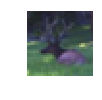

deer


In [23]:
n = 38247
#img_batch = image_batch[b'data']
#import numpy as np
#img_rgb = img.reshape((3,32,32)).transpose((1,2,0))
img_rgb = image_data[n]
import matplotlib.pyplot as plt
plt.figure(figsize=(1.2,1.2))
plt.axis('off')
plt.imshow(img_rgb)
plt.show()
print(label_names[image_labels[n]])

In [58]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%dT%H%M%S")
root_logdir = "./log"
logdir = "{}/run-{}/".format(root_logdir, now)

# Don't write graph to filewriter to allow live monitoring? Write graph to different log?
file_writer_train = tf.summary.FileWriter(logdir + '/train')
file_writer_test = tf.summary.FileWriter(logdir + 'test')

# tensorboard --logdir e:\Programming\TensorFlow\CIFAR-10\log
# Must be executed from same drive (E:) as log-dir

In [61]:
import tensorflow as tf
height = 32
width = 32
channels = 3

def build_graph():
    graph = tf.Graph()
    with graph.as_default():
        X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
        y = tf.placeholder(shape=(None), dtype=tf.int32)

        conv1 = tf.layers.conv2d(X, filters=4, kernel_size=5, strides=[2,2], padding="SAME")
        max_pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
        conv2 = tf.layers.conv2d(max_pool1, filters=4, kernel_size=5, strides=[2,2], padding="SAME")
        max_pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

        fully_conn = tf.layers.dense(max_pool2, 100, name="fully_conn", activation=tf.nn.relu)
        flat = tf.contrib.layers.flatten(fully_conn)
        logits = tf.layers.dense(flat, 10, name="logits")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name="loss")

        learning_rate = 0.01
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate)
            training_op = optimizer.minimize(loss)
    
        init = tf.global_variables_initializer()
        saver = tf.train.Saver() 
        
        return graph, X, y, logits, loss, training_op, init, saver


In [ ]:
n_epochs = 2
batch_size = 1000
training_size = image_data.shape[0]

no_batches = training_size // batch_size
acc_check = 10

tf.reset_default_graph()

graph, X, y, logits, loss, training_op, init, saver = build_graph()

with graph.as_default():
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        acc_summary = tf.summary.scalar('Accuracy', accuracy)
        loss_summary = tf.summary.scalar('Loss', loss)
    

with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(no_batches):
            X_batch = image_data[iteration * batch_size:(iteration + 1) * batch_size + 1]
            y_batch = image_labels[iteration * batch_size:(iteration + 1) * batch_size + 1]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if (iteration % acc_check == 0):
                acc_train = accuracy.eval(feed_dict={X: image_data, y: image_labels})
                acc_test = accuracy.eval(feed_dict={X: test_data, y: test_labels})
                summary_str_acc_train = acc_summary.eval(feed_dict={X: image_data, y: image_labels})
                summary_str_acc_test = acc_summary.eval(feed_dict={X: test_data, y: test_labels})
                summary_str_loss_train = loss_summary.eval(feed_dict={X: image_data, y: image_labels})
                summary_str_loss_test = loss_summary.eval(feed_dict={X: test_data, y: test_labels})
                file_writer_train.add_summary(summary_str_acc_train, epoch * no_batches + iteration)
                file_writer_test.add_summary(summary_str_acc_test, epoch * no_batches + iteration)
                file_writer_train.add_summary(summary_str_loss_train, epoch * no_batches + iteration)
                file_writer_test.add_summary(summary_str_loss_test, epoch * no_batches + iteration)
                print(epoch, iteration, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

file_writer_train.close()
file_writer_test.close()

0 0 Train accuracy: 0.102925 Test accuracy: 0.1033
0 10 Train accuracy: 0.099925 Test accuracy: 0.099


In [43]:
5 % 2

1